# <font color='teal'> Homework 5</font>

------
### Information
**Name:** Ahmed Ibrahim

**Student Number:** 261032796

**Date:** 2022-02-22

**Course Number:** YCBS 258 - Practical Machine Learning

------
# MNIST Autoencoder
### Directives
* Create the autoencoders described below, you can play with the topology, those are just starting points
* Use GPU runtime
* Print 10 inputs and their associated outputs
* Don't forget to normalize your data
* Use the Functional API for Keras

### Autoencoders to build
1. Stacked 784 - 392 - 196 - 392 - 784 (tied weights)
2. Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)


## Starter Code

In [ ]:
# Choose Python 3 runtime
!pip install --upgrade tensorflow

In [ ]:
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(X_train, _), (X_test, _) = mnist.load_data()
all_data = np.concatenate((X_train, X_test))
all_data.shape

(70000, 28, 28)

In [ ]:
def print_first_9(data):
  fig = plt.figure()
  for i in range(9):
    plt.subplot(3,3,i+1)
    plt.tight_layout()
    plt.imshow(data[i], interpolation='none')
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

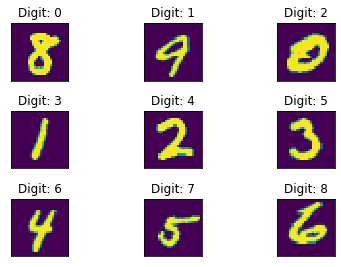

In [ ]:
print_first_9(all_data[-9:])

## Data Mining

### Setup Environnment

In [ ]:
# Check if running in colab.
import sys
print ('Running in colab:', 'google.colab' in sys.modules)

Running in colab: True


In [ ]:
# Check connection to a GPU.
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Wed Feb 23 02:26:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Check RAM runtime.
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# Check CPU specs.
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_sin

### Import libraries, modules and dataset

In [ ]:
import random
random.seed(12)
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf

In [ ]:
# Choose Python 3 runtime
!pip install --upgrade tensorflow

     |████████████████████████████████| 462 kB 9.1 MB/s 


In [ ]:
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.layers import Dense, Reshape, Conv2D, MaxPool2D, UpSampling2D

In [ ]:
# Load data.
from keras.datasets import mnist
mnist_digits_data = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


## Data Exploration

In [ ]:
# Check data shape.
(X_train, _), (X_test, _) = mnist_digits_data
mnist_digits_data = np.concatenate((X_train, X_test))
mnist_digits_data.shape

(70000, 28, 28)

In [ ]:
# Check data type.
mnist_digits_data.dtype

dtype('uint8')

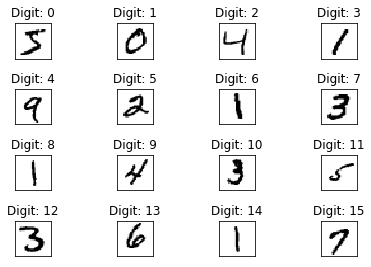

In [ ]:
# Visualize sample of images.
fig = plt.figure()
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.tight_layout()
    plt.imshow(mnist_digits_data[i], interpolation = 'none', cmap = "binary")
    plt.title("Digit: {}".format(i))
    plt.xticks([])
    plt.yticks([])

## Data Cleaning

In [ ]:
# Normalize pixels for X_train and X_test.
X_train_c = X_train.astype('float32')/255.0
X_test_c = X_test.astype('float32')/255.0
print(f'X_train: {X_train_c.dtype}')
print(f'X_test: {X_test_c.dtype}')

X_train: float32
X_test: float32


## Predictive Modeling

### Functions for both autoencoders

In [ ]:
# Function to plot image.
def plot_image(image):
    plt.imshow(image, cmap = "binary")
    plt.axis("off")

In [ ]:
# Function to print 10 inputs and their associated outputs.
def show_reconstructions(model, test_images):
  n_images = 10
  reconstructions = model.predict(test_images[:n_images])
  fig = plt.figure(figsize=(n_images * 1.5, 3))
  for image_index in range(n_images):
      plt.subplot(2, n_images, 1 + image_index)
      plot_image(test_images[image_index].reshape(28, 28))
      plt.subplot(2, n_images, 1 + n_images + image_index)
      plot_image(reconstructions[image_index].reshape(28, 28))

In [ ]:
# Function for rounded accuracy.
def rounded_accuracy(y_true, y_pred):
    return tf.keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

### Autoencoder #1

#### Model topology : Stacked 784 - 392 - 196 - 392 - 784 (tied weights)

In [ ]:
# Function for tying weights.
class DenseTranspose(tf.keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = tf.keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name = "bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer = "zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b = True)
        return self.activation(z + self.biases)

In [ ]:
# Function to run the 'autoencoder #1'.
def stacked_autoencoder(data_train, data_test):
    K.clear_session()

    dense_1 = tf.keras.layers.Dense(784, activation = 'selu')
    dense_2 = tf.keras.layers.Dense(392, activation = 'selu')
    dense_3 = tf.keras.layers.Dense(196, activation = 'selu')

    inputs = tf.keras.Input(shape = (28, 28))
    flattened_inputs = tf.keras.layers.Flatten()(inputs)
    encoder_1 = dense_1(flattened_inputs)
    encoder_2 = dense_2(encoder_1)
    encoded = dense_3(encoder_2)

    decoder_1 = DenseTranspose(dense_3, activation = 'selu')(encoded)
    decoder_2 = DenseTranspose(dense_2, activation = 'selu')(decoder_1)
    decoder_3 = DenseTranspose(dense_1, activation = 'sigmoid')(decoder_2)
    outputs = tf.keras.layers.Reshape([28, 28])(decoder_3)

    tied_autoencoder = tf.keras.Model(inputs = inputs, outputs = outputs)
    tied_autoencoder.compile(loss = "binary_crossentropy",
                                optimizer = tf.keras.optimizers.SGD(learning_rate = 1.5), 
                                metrics = [rounded_accuracy])
    tied_autoencoder.summary()          
    history = tied_autoencoder.fit(data_train, data_train, epochs = 20, validation_data = [data_test, data_test])

    return tied_autoencoder, history

In [ ]:
# Run the 'autoencoder #1'.
experiement_1 = stacked_autoencoder(X_train_c, X_test_c)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 784)               615440    
                                                                 
 dense_1 (Dense)             (None, 392)               307720    
                                                                 
 dense_2 (Dense)             (None, 196)               77028     
                                                                 
 dense_transpose (DenseTrans  (None, 392)              77420     
 pose)                                                           
                                                             

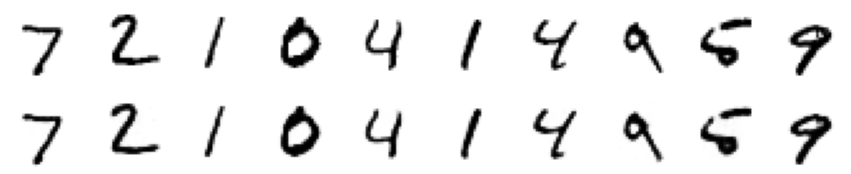

In [ ]:
# Print 10 inputs and their associated outputs for the 'autoencoder #1'.
show_reconstructions(experiement_1[0], X_test_c)

### Autoencoder #2

#### Model Topology: Convolutional Encoder (conv, maxpool, conv, maxpool, conv, maxpool). Decoder (conv, upsample2d, conv, upsample2d, conv, upsample2d, conv)

In [ ]:
# Function to run the 'autoencoder #2'.
def conv_autoencoder(data_train, data_test):
    K.clear_session()

    inputs = tf.keras.Input(shape = (28, 28))
    inputs_reshaped = tf.keras.layers.Reshape([28, 28, 1])(inputs)
    encoder_conv2d_1 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'selu', padding = 'same')(inputs_reshaped)
    encoder_maxpool2d_1 = tf.keras.layers.MaxPool2D((2,2), padding = 'same')(encoder_conv2d_1)
    encoder_conv2d_2 = tf.keras.layers.Conv2D(8, (3, 3), activation = 'selu', padding = 'same')(encoder_maxpool2d_1)
    encoder_maxpool2d_2 = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(encoder_conv2d_2)
    encoder_conv2d_3 = tf.keras.layers.Conv2D(8, (3, 3), activation = 'selu', padding = 'same')(encoder_maxpool2d_2)
    encoded = tf.keras.layers.MaxPool2D(pool_size = 2, padding = 'same')(encoder_conv2d_3)

    decoder_conv2d_1 = tf.keras.layers.Conv2D(8, (3, 3), activation = 'selu', padding = 'same')(encoded)
    decoder_maxpool2d_1 = UpSampling2D(size = (2, 2))(decoder_conv2d_1)
    decoder_conv2d_2 = tf.keras.layers.Conv2D(8, (3, 3), activation = 'selu', padding = 'same')(decoder_maxpool2d_1)
    decoder_maxpool2d_2 = UpSampling2D(size = (2, 2))(decoder_conv2d_2)
    decoder_conv2d_3 = tf.keras.layers.Conv2D(16, (3, 3), activation = 'selu', padding = 'valid')(decoder_maxpool2d_2)
    decoder_maxpool2d_3 = UpSampling2D(size = (2, 2))(decoder_conv2d_3)
    outputs = tf.keras.layers.Conv2D(1, (3, 3), activation = 'sigmoid', padding = 'same')(decoder_maxpool2d_3)

    conv2d_autoencoder = tf.keras.Model(inputs = inputs, outputs = outputs)
    conv2d_autoencoder.compile(loss = "binary_crossentropy",
                                optimizer = 'adam', 
                                metrics = [rounded_accuracy])
    conv2d_autoencoder.summary()          
    history = conv2d_autoencoder.fit(data_train, data_train, epochs = 20, validation_data = [data_test, data_test])

    return conv2d_autoencoder, history

In [ ]:
# Run the 'autoencoder #2'.
experiement_2 = conv_autoencoder(X_train_c, X_test_c)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 reshape (Reshape)           (None, 28, 28, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 16)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 8)         1160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 8)          0         
 2D)                                                         

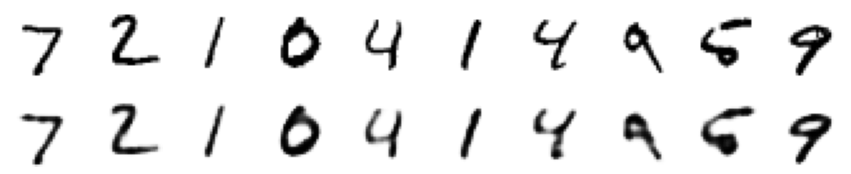

In [ ]:
# Print 10 inputs and their associated outputs for the 'initial autoencoder #2'.
show_reconstructions(experiement_2[0], X_test_c)